# Using the Python API

<a target="_blank" href="https://colab.research.google.com/github/RobbinBouwmeester/Workshop_Grenoble_2025/blob/main/in-depth-python-api.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install plotly ms2rescore==3.1.4 im2deep==1.0.2 psm_utils==1.4.0


In [43]:
import logging
import plotly.io
import os
import requests
import tarfile
import pickle

from psm_utils.io import read_file
from ms2rescore.report.charts import score_histogram

logging.basicConfig(level=logging.INFO)
plotly.io.renderers.default = "colab"

## Obtaining the sequence database, sage, configuration, and run the search

Download mgf data:

In [4]:
import urllib.request

url = "https://genesis.ugent.be/uvpublicdata/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf"
output_path = "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf


Download the appropiate fasta (includes human, yeast, and *E. coli*):

In [5]:
url = "https://github.com/compomics/Workshop_Grenoble_2025/raw/refs/heads/main/database/puyvelde.fasta"
output_path = "puyvelde.fasta"
extract_dir = "./"


urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: puyvelde.fasta


Download the executable from sage, extract the executable, and make it runnable executable:

In [6]:
# Define URL and file paths
url = "https://github.com/lazear/sage/releases/download/v0.14.7/sage-v0.14.7-x86_64-unknown-linux-gnu.tar.gz"
archive_path = "sage-v0.14.7.tar.gz"
extract_dir = "./"
bin_sage_loc = "sage-v0.14.7-x86_64-unknown-linux-gnu/sage"

# Step 1: Download the file
print("Downloading archive...")
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(archive_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Downloaded archive to: {archive_path}")

# Step 2: Extract the tar.gz file
print("Extracting archive...")
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print(f"Extracted to directory: {extract_dir}")

# Set executable permission (equivalent to chmod +x)
os.chmod(bin_sage_loc, os.stat(bin_sage_loc).st_mode | 0o111)

Downloaded archive to: sage-v0.14.7.tar.gz
Extracting archive...
Extracted to directory: ./


Download the parameters to run sage:

In [ ]:
url = "https://github.com/compomics/Workshop_Grenoble_2025/raw/refs/heads/main/json/params.json"
output_path = "params.json"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

We are skipping this step in colab, as we only have limited resources, but this cell (without starting with the "#" can be used to run sage:

In [ ]:
#!{bin_sage_loc} params.json

Instead of running sage, download the results:

In [9]:
url = "https://raw.githubusercontent.com/compomics/Workshop_Grenoble_2025/refs/heads/main/results/results.sage.tsv"
output_path = "results.sage.tsv"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: results.sage.tsv


Download the result pickle:

In [45]:
url = "https://genesis.ugent.be/uvpublicdata/psm_list.pkl"
output_path = "psm_list.pkl"

urllib.request.urlretrieve(url, output_path)
print(f"Downloaded to: {output_path}")

Downloaded to: psm_list.pkl


### Reading the PSM file

MS²Rescore is fully centered around the use of a `psm_utils` PSMList. This is a unified data representation of PSMs and their various attributes. Internally, it is simply a list of Pydantic data classes which represent PSMs. With the submodule `psm_utils.io`, we can read PSMs from a variety of file formats. Here, we will read a PSM file in the MaxQuant `msms.txt` format.

Importantly, for rescoring, the PSM file must contain all target and decoy PSMs, including PSMs that did not pass the FDR threshold. Most search engines must be specifically configured to return all PSMs without FDR filtering.


In [46]:
psm_list = read_file("results.sage.tsv", filetype="sage_tsv")
psm_list["spectrum_id"] = [str(spec_id) for spec_id in psm_list["spectrum_id"]]

For a quick inspection, we can format the PSM list as a Pandas dataframe and display the first few rows:

In [47]:
psm_list.to_dataframe().head()

peptidoform  \
0  ((V, None), (N, None), (L, None), (D, None), (...   
1  ((A, None), (N, None), (C, [+57.0215]), (I, No...   
2  ((V, None), (L, None), (P, None), (G, None), (...   
3  ((I, None), (I, None), (P, None), (G, None), (...   
4  ((I, None), (S, None), (F, None), (G, None), (...   

                                       spectrum_id  \
0  controllerType=0 controllerNumber=1 scan=103797   
1   controllerType=0 controllerNumber=1 scan=86089   
2  controllerType=0 controllerNumber=1 scan=114631   
3   controllerType=0 controllerNumber=1 scan=95243   
4  controllerType=0 controllerNumber=1 scan=107044   

                                            run collection spectrum  is_decoy  \
0  LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01       None     None     False   
1  LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01       None     None     False   
2  LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01       None     None     False   
3  LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01       None     None     False   
4  LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01       None     None     False   

      score    qvalue   pep  precursor_mz  retention_time ion_mobility  \
0  1.032798  0.000029  None    951.456375      108.346390         None   
1  1.011054  0.000029  None    884.913175       94.262850         None   
2  1.009445  0.000029  None    911.457025      117.217010         None   
3  1.006775  0.000029  None    533.587492      101.494194         None   
4  1.002428  0.000029  None    909.923825      110.985085         None   

                                    protein_list  rank source  \
0                          [sp|P14540|ALF_YEAST]     1   sage   
1                         [sp|P15646|FBRL_YEAST]     1   sage   
2                        [sp|Q96AB3|ISOC2_HUMAN]     1   sage   
3  [sp|P62937|PPIA_HUMAN, sp|Q9Y536|PAL4A_HUMAN]     1   sage   
4                        [sp|Q06265|EXOS9_HUMAN]     1   sage   

                         provenance_data metadata  \
0  {'sage_filename': 'results.sage.tsv'}       {}   
1  {'sage_filename': 'results.sage.tsv'}       {}   
2  {'sage_filename': 'results.sage.tsv'}       {}   
3  {'sage_filename': 'results.sage.tsv'}       {}   
4  {'sage_filename': 'results.sage.tsv'}       {}   

                                  rescoring_features  
0  {'expmass': 1900.8971, 'calcmass': 1900.8992, ...  
1  {'expmass': 1767.8107, 'calcmass': 1767.8096, ...  
2  {'expmass': 1820.8984, 'calcmass': 1821.9006, ...  
3  {'expmass': 1597.739, 'calcmass': 1597.7382, '...  
4  {'expmass': 1817.832, 'calcmass': 1817.833, 'p...

We can also directly plot the current PSM score distributions:

In [48]:
score_histogram(psm_list)

### Parsing modification names

While `psm_utils` could take care of all file parsing, we must still map the amino acid modification names that were used by the search engine to ones that are recognized by tools such as MS²PiP and DeepLC. This includes:

- Names as used in the Unimod or PSI-MOD databases
- Accession numbers as used in the Unimod or PSI-MOD databases
- Chemical formulas
- Mass shifts in Da

Note that, for instance DeepLC, requires a chemical formula to encode modifications. It will not be able to correctly encode modifications if only the mass shift is provided. It is therefore always preferred to provide a name/accession of a database where this information can be retrieved, or provide the chemical formula directly.

If a chemical formula is provided, other tools, such as MS²PIP, can use it to derive the correct mass shift.

To map modification names, simply provide a dictionary to the `psm_list.map_modifications` method.

In [49]:
psm_list.rename_modifications({
    "-17.026548": "Gln->pyro-Glu",
    "-18.010565": "Glu->pyro-Glu",
    "+15.9949": "Oxidation",
    "+57.0215": "Carbamidomethyl"
})

### Assigning fixed modifications

Some search engines (although not many) do not report fixed (sometimes also called static) modifications in their output PSM files. This is for instance the case for MaxQuant. With the method `psm_list.add_fixed_modifications`, we can systematically assign fixed modifications to their amino acid targets, as was done during the search.

Note that `add_fixed_modifications` adds the modification in the ProForma 2.0 encoding as a prefix. To fully apply the modifications in the sequence, use the `psm_list.apply_fixed_modifications` method. A PSM `ACDE/2` would therefore go from `<[U:4]@C>ACDE/2` to `AC[U:4]DE/2`.



In [50]:
psm_list.add_fixed_modifications([("U:Carbamidomethyl", ["C"])])
psm_list.apply_fixed_modifications()

## Adding rescoring features

In [51]:
import pandas as pd

from ms2rescore.feature_generators.basic import BasicFeatureGenerator
from ms2rescore.feature_generators.ms2pip import MS2PIPFeatureGenerator
from ms2rescore.feature_generators.deeplc import DeepLCFeatureGenerator

The PSM list, as read from a MaxQuant msms.txt file, currently does not contain any rescoring features:

In [52]:
pd.DataFrame(list(psm_list["rescoring_features"]))

expmass   calcmass  peptide_len  missed_cleavages  isotope_error  \
0      1900.8971  1900.8992         16.0               0.0        0.00000   
1      1767.8107  1767.8096         16.0               0.0        0.00000   
2      1820.8984  1821.9006         16.0               0.0       -1.00335   
3      1597.7390  1597.7382         14.0               0.0        0.00000   
4      1817.8320  1817.8330         16.0               0.0        0.00000   
...          ...        ...          ...               ...            ...   
77450  4864.8720  4864.8765         42.0               0.0        0.00000   
77451  4117.4473  4117.4470         36.0               1.0        0.00000   
77452  4117.4530  4117.4470         36.0               1.0        0.00000   
77453  1350.4752  1350.4752         12.0               0.0        0.00000   
77454  4117.4624  4117.4470         36.0               1.0        0.00000   

       precursor_ppm  fragment_ppm  hyperscore  delta_next  delta_best  ...  \
0           1.091692      3.718676   46.529966   46.529966         0.0  ...   
1           0.621465      1.741814   51.018449   51.018449         0.0  ...   
2           0.632720      4.596551   46.628815   46.628815         0.0  ...   
3           0.534814      3.528885   44.283962   44.283962         0.0  ...   
4           0.537213      2.841284   45.210311   45.210311         0.0  ...   
...              ...           ...         ...         ...         ...  ...   
77450       0.903319      8.671374   26.033297   26.033297         0.0  ...   
77451       0.118588      4.290805   64.185677   64.185677         0.0  ...   
77452       1.541647      2.112757   70.038910   70.038910         0.0  ...   
77453       0.000000      1.785237   43.475036   43.475036         0.0  ...   
77454       3.794820      1.477869   75.266006   75.266006         0.0  ...   

       aligned_rt  predicted_rt  matched_peaks  longest_b  longest_y  \
0        0.796665      0.792314           14.0        1.0       13.0   
1        0.693109      0.695794           15.0        2.0       13.0   
2        0.861890      0.858764           14.0        1.0       12.0   
3        0.746281      0.743987           13.0        1.0       11.0   
4        0.816067      0.805724           13.0        1.0       12.0   
...           ...           ...            ...        ...        ...   
77450    0.610412      0.280211            6.0        3.0        1.0   
77451    0.587692      0.591934           22.0       11.0       11.0   
77452    0.587614      0.591934           23.0       10.0       12.0   
77453    0.432287      0.398073           13.0        4.0        9.0   
77454    0.591352      0.591934           25.0       10.0       15.0   

       longest_y_pct  matched_intensity_pct  scored_candidates    poisson  \
0           0.812500              19.441456              633.0 -11.427653   
1           0.812500              45.418945              596.0 -12.365314   
2           0.750000              18.175797             1491.0 -11.078708   
3           0.785714              23.340055              579.0 -10.262999   
4           0.750000              51.255890              513.0 -10.102216   
...              ...                    ...                ...        ...   
77450       0.023810               6.474505                1.0  -1.177241   
77451       0.305556              14.810387                4.0  -6.925313   
77452       0.333333              27.063044                4.0  -7.217692   
77453       0.750000              48.182804                1.0  -1.587603   
77454       0.416667              28.089870                3.0  -6.205751   

       ms2_intensity  
0          311409.16  
1         1266331.90  
2          683937.06  
3          707095.56  
4          728470.20  
...              ...  
77450       89627.84  
77451     1319046.40  
77452     6506783.00  
77453      929068.70  
77454     5954682.00  

[77455 rows x 21 columns]

Note that `psm_list[rescoring_features]` returns a Numpy array of dictionaries, but we can use Pandas to format it as a table.

### Basic features

Basic features from `BasicFeatureGenerator` can be added from any PSM list and contain simple feature, such as the search engine score, charge state, and absolute precursor mass error.

In [53]:
basic_fgen = BasicFeatureGenerator()
basic_fgen.add_features(psm_list)

In [54]:
pd.DataFrame(list(psm_list["rescoring_features"]))

expmass   calcmass  peptide_len  missed_cleavages  isotope_error  \
0      1900.8971  1900.8992         16.0               0.0        0.00000   
1      1767.8107  1767.8096         16.0               0.0        0.00000   
2      1820.8984  1821.9006         16.0               0.0       -1.00335   
3      1597.7390  1597.7382         14.0               0.0        0.00000   
4      1817.8320  1817.8330         16.0               0.0        0.00000   
...          ...        ...          ...               ...            ...   
77450  4864.8720  4864.8765         42.0               0.0        0.00000   
77451  4117.4473  4117.4470         36.0               1.0        0.00000   
77452  4117.4530  4117.4470         36.0               1.0        0.00000   
77453  1350.4752  1350.4752         12.0               0.0        0.00000   
77454  4117.4624  4117.4470         36.0               1.0        0.00000   

       precursor_ppm  fragment_ppm  hyperscore  delta_next  delta_best  ...  \
0           1.091692      3.718676   46.529966   46.529966         0.0  ...   
1           0.621465      1.741814   51.018449   51.018449         0.0  ...   
2           0.632720      4.596551   46.628815   46.628815         0.0  ...   
3           0.534814      3.528885   44.283962   44.283962         0.0  ...   
4           0.537213      2.841284   45.210311   45.210311         0.0  ...   
...              ...           ...         ...         ...         ...  ...   
77450       0.903319      8.671374   26.033297   26.033297         0.0  ...   
77451       0.118588      4.290805   64.185677   64.185677         0.0  ...   
77452       1.541647      2.112757   70.038910   70.038910         0.0  ...   
77453       0.000000      1.785237   43.475036   43.475036         0.0  ...   
77454       3.794820      1.477869   75.266006   75.266006         0.0  ...   

       scored_candidates    poisson  ms2_intensity  charge_n  charge_2  \
0                  633.0 -11.427653      311409.16         2         1   
1                  596.0 -12.365314     1266331.90         2         1   
2                 1491.0 -11.078708      683937.06         2         1   
3                  579.0 -10.262999      707095.56         3         0   
4                  513.0 -10.102216      728470.20         2         1   
...                  ...        ...            ...       ...       ...   
77450                1.0  -1.177241       89627.84         5         0   
77451                4.0  -6.925313     1319046.40         4         0   
77452                4.0  -7.217692     6506783.00         3         0   
77453                1.0  -1.587603      929068.70         2         1   
77454                3.0  -6.205751     5954682.00         3         0   

       charge_3  charge_4  charge_5  abs_ms1_error_ppm  search_engine_score  
0             0         0         0       29094.458214             1.032798  
1             0         0         0       31212.537942             1.011054  
2             0         0         0       30848.209340             1.009445  
3             1         0         0       34395.684591             1.006775  
4             0         0         0       58971.117273             1.002428  
...         ...       ...       ...                ...                  ...  
77450         0         0         1       75754.428836            -0.108037  
77451         0         1         0           0.247638            -0.120033  
77452         1         0         0           1.135638            -0.146931  
77453         0         0         0      112279.688600            -0.360481  
77454         1         0         0           3.416930            -0.405298  

[77455 rows x 28 columns]

Now the PSMs contain a simple set of features.

Note that the charge state is present as both an integer and a one-hot encoded vector. This is because charge state can act as both a categorical and a numerical feature. Simply put, sometimes an effect increases or decreases with increasing charge state, and sometimes it is simply different for different charge states.

### MS²PIP features

MS²PIP is a machine learning tool that predicts the MS2 spectrum of a peptide given its sequence. It is previously identified MS2 spectra and their corresponding peptide sequences. Because MS²PIP uses the highly performant - but traditional - machine learning approach XGBoost, it can already produce accurate predictions even if trained on smaller spectral libraries. This makes MS²PIP a very flexible platform to train new models on custom datasets. Nevertheless, MS²PIP comes with several pre-trained models, which we will use in this tutorial.

Because traditional proteomics search engines do not fully consider MS2 peak intensities in their scoring functions, adding rescoring features derived from spectrum prediction tools has proved to be a very effective way to further improve the sensitivity of peptide-spectrum matching. Generating features from MS²PIP predictions follows these steps:

1. Predict MS2 spectra for all PSMs in the dataset, including decoy PSMs and low scoring target PSMs.
2. Read and parse the observed MS2 spectra from the original spectrum files (MGF or mzML).
3. Compare the predicted and observed spectra using various similarity metrics, which are returned as rescoring features.


#### Configuring MS²PIP

In contrast to the basic feature generator, MS²PIP requires some parameters to be set and requires access to the original observed peptide spectra:

- `model`: Name of the prediction model to be used. This strongly depends on the dataset your are rescoring. A list of all MS²PIP models is available on https://ms2pip.readthedocs.io/en/latest/prediction-models/.
- `ms2_tolerance`: As MS²PIP must reannotate the observed MS2 spectra, a mass tolerance must be set. For MS²PIP, this is configured in Dalton. A good value for Orbitrap spectra, for example, is `0.02`.
- `spectrum_path`: Path to the original spectrum files. This can be a single file, or a directory containing multiple files. The spectrum files must be in MGF or mzML format.
- `processes`: Number of CPU processes to use for parallel processing. Note that higher values can lead to memory issues.

In [19]:
#ms2pip_fgen = MS2PIPFeatureGenerator(
#    model="HCD",
#    ms2_tolerance=0.02,
#    spectrum_path="LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf",
#    processes=8,
#)

#### Generating MS²PIP features

Due to hardware constraints on Google Colab we are going to skip the prediction step and read in a file we saved before that contains predictions.

In [23]:
#ms2pip_fgen.add_features(psm_list)

Output()

In [55]:
with open('psm_list.pkl', 'rb') as f:
    psm_list = pickle.load(f)

In [56]:
pd.DataFrame(list(psm_list["rescoring_features"]))

expmass   calcmass  peptide_len  missed_cleavages  isotope_error  \
0      1900.8971  1900.8992         16.0               0.0        0.00000   
1      1767.8107  1767.8096         16.0               0.0        0.00000   
2      1820.8984  1821.9006         16.0               0.0       -1.00335   
3      1597.7390  1597.7382         14.0               0.0        0.00000   
4      1817.8320  1817.8330         16.0               0.0        0.00000   
...          ...        ...          ...               ...            ...   
77450  4864.8720  4864.8765         42.0               0.0        0.00000   
77451  4117.4473  4117.4470         36.0               1.0        0.00000   
77452  4117.4530  4117.4470         36.0               1.0        0.00000   
77453  1350.4752  1350.4752         12.0               0.0        0.00000   
77454  4117.4624  4117.4470         36.0               1.0        0.00000   

       precursor_ppm  fragment_ppm  hyperscore  delta_next  delta_best  ...  \
0           1.091692      3.718676   46.529966   46.529966         0.0  ...   
1           0.621465      1.741814   51.018449   51.018449         0.0  ...   
2           0.632720      4.596551   46.628815   46.628815         0.0  ...   
3           0.534814      3.528885   44.283962   44.283962         0.0  ...   
4           0.537213      2.841284   45.210311   45.210311         0.0  ...   
...              ...           ...         ...         ...         ...  ...   
77450       0.903319      8.671374   26.033297   26.033297         0.0  ...   
77451       0.118588      4.290805   64.185677   64.185677         0.0  ...   
77452       1.541647      2.112757   70.038910   70.038910         0.0  ...   
77453       0.000000      1.785237   43.475036   43.475036         0.0  ...   
77454       3.794820      1.477869   75.266006   75.266006         0.0  ...   

       dotprod_iony       cos  cos_ionb  cos_iony  observed_retention_time  \
0          0.001272  0.694201  0.991779  0.778397               108.346390   
1          0.005297  0.845373  0.260489  0.950089                94.262850   
2          0.000178  0.325728  0.870120  0.288095               117.217010   
3          0.003517  0.912657  0.994404  0.915884               101.494194   
4          0.002674  0.675445  0.992833  0.682687               110.985085   
...             ...       ...       ...       ...                      ...   
77450      0.000032  0.442166  0.624701  0.349432                83.016075   
77451      0.000572  0.829348  0.712537  0.916901                79.926130   
77452      0.000989  0.852344  0.950212  0.901506                79.915530   
77453      0.005862  0.740783  0.053412  0.809620                58.791004   
77454      0.001074  0.863733  0.948495  0.908646                80.423810   

       predicted_retention_time    rt_diff  observed_retention_time_best  \
0                    105.585884   2.760506                    105.668460   
1                     92.295716   1.967134                     94.262850   
2                    116.050539   1.166471                    117.217010   
3                     95.726896   5.767298                    101.494194   
4                    106.809460   4.175625                    110.985085   
...                         ...        ...                           ...   
77450                 74.802975   8.213100                     83.016075   
77451                 66.311031  13.615099                     79.926130   
77452                 66.311031  13.604499                     79.915530   
77453                 38.869533  19.921471                     58.791004   
77454                 66.311031  14.112779                     79.915530   

       predicted_retention_time_best  rt_diff_best  
0                         105.585884      0.082576  
1                          92.295716      1.967134  
2                         116.050539      1.166471  
3                          95.726896      5.767298  
4                   

### Generating DeepLC features

Due to hardware constraints on Google Colab we are going to skip the prediction step and read in a file we saved before that contains predictions.

In [57]:
#deeplc_fgen = DeepLCFeatureGenerator(
#    lower_score_is_better=False,
#    spectrum_path=None,
#    processes=1,
#    deeplc_retrain=False,
#)

#deeplc_fgen.add_features(psm_list)

In [58]:
with open('psm_list.pkl', 'rb') as f:
    psm_list = pickle.load(f)

### Assessing individual feature performance before rescoring

In [26]:
import plotly.express as px
from ms2rescore.report.charts import (
    calculate_feature_qvalues,
    feature_ecdf_auc_bar,
    fdr_plot,
    ms2pip_correlation,
)
import deeplc.plot

features = pd.DataFrame(list(psm_list["rescoring_features"]))

The following plot shows the number of identified PSM at varying FDR thresholds, where the red line indicates the commonly used 1% FDR threshold.

In [27]:
psm_list.calculate_qvalues()  # msms.txt does not contain q-values
fig = fdr_plot(psm_list.to_dataframe(), fdr_thresholds=None, log=False)
fig.show()

We can make a similar plot for each of the rescoring features by simply calculating q-values as if the feature were a search engine score.

In [28]:
feature_qvalues, feature_ecdf_auc = calculate_feature_qvalues(
    features=features,
    is_decoy=psm_list["is_decoy"],
)

In [29]:
feature_names = {
    "basic": basic_fgen.feature_names,
    "ms2pip": ms2pip_fgen.feature_names,
    "deeplc": deeplc_fgen.feature_names,
}
feature_generator_map = {name: gen for gen, f_list in feature_names.items() for name in f_list}

feature_qvalues_melt = feature_qvalues.melt(var_name="feature", value_name="q-value")
feature_qvalues_melt["feature_generator"] = feature_qvalues_melt["feature"].map(feature_generator_map)

The larger the area under the curve (AUC) is for each line, the better. We can therefore visualize the same information in a more easy-to-interpret bar chart with the AUCs, which were already calculated by the `calculate_feature_qvalues` function.

In [30]:
feature_ecdf_auc["feature_generator"] = feature_ecdf_auc["feature"].map(feature_generator_map)

In [31]:
fig = feature_ecdf_auc_bar(feature_ecdf_auc)
fig.show()

Importantly, a low q-value ECDF AUC does not necessarily mean that a feature is not valuable for rescoring. The more orthogonal a feature is to the other information already used in PSM scoring, the more it will help to confidently identify PSMs. For instance, retention time features are completely independent from the information used in a traditional search engine. When combined with other scoring information, they can provide a substantial boost in sensitivity.

The quality of specific rescoring features can also be assessed in a manner specific to the feature. For instance, we can plot the distribution of the MS²PIP pearson correlations for target PSMs that initially passed the FDR threshold:

In [32]:
fig = ms2pip_correlation(
    features=features,
    is_decoy=psm_list["is_decoy"],
    qvalue=psm_list["qvalue"]
)
fig.show()

In [33]:
pd.DataFrame(list(psm_list["rescoring_features"]))

expmass   calcmass  peptide_len  missed_cleavages  isotope_error  \
0      1900.8971  1900.8992         16.0               0.0        0.00000   
1      1767.8107  1767.8096         16.0               0.0        0.00000   
2      1820.8984  1821.9006         16.0               0.0       -1.00335   
3      1597.7390  1597.7382         14.0               0.0        0.00000   
4      1817.8320  1817.8330         16.0               0.0        0.00000   
...          ...        ...          ...               ...            ...   
77450  4864.8720  4864.8765         42.0               0.0        0.00000   
77451  4117.4473  4117.4470         36.0               1.0        0.00000   
77452  4117.4530  4117.4470         36.0               1.0        0.00000   
77453  1350.4752  1350.4752         12.0               0.0        0.00000   
77454  4117.4624  4117.4470         36.0               1.0        0.00000   

       precursor_ppm  fragment_ppm  hyperscore  delta_next  delta_best  ...  \
0           1.091692      3.718676   46.529966   46.529966         0.0  ...   
1           0.621465      1.741814   51.018449   51.018449         0.0  ...   
2           0.632720      4.596551   46.628815   46.628815         0.0  ...   
3           0.534814      3.528885   44.283962   44.283962         0.0  ...   
4           0.537213      2.841284   45.210311   45.210311         0.0  ...   
...              ...           ...         ...         ...         ...  ...   
77450       0.903319      8.671374   26.033297   26.033297         0.0  ...   
77451       0.118588      4.290805   64.185677   64.185677         0.0  ...   
77452       1.541647      2.112757   70.038910   70.038910         0.0  ...   
77453       0.000000      1.785237   43.475036   43.475036         0.0  ...   
77454       3.794820      1.477869   75.266006   75.266006         0.0  ...   

       dotprod_iony       cos  cos_ionb  cos_iony  observed_retention_time  \
0          0.001272  0.694201  0.991779  0.778397               108.346390   
1          0.005297  0.845373  0.260489  0.950089                94.262850   
2          0.000178  0.325728  0.870120  0.288095               117.217010   
3          0.003517  0.912657  0.994404  0.915884               101.494194   
4          0.002674  0.675445  0.992833  0.682687               110.985085   
...             ...       ...       ...       ...                      ...   
77450      0.000032  0.442166  0.624701  0.349432                83.016075   
77451      0.000572  0.829348  0.712537  0.916901                79.926130   
77452      0.000989  0.852344  0.950212  0.901506                79.915530   
77453      0.005862  0.740783  0.053412  0.809620                58.791004   
77454      0.001074  0.863733  0.948495  0.908646                80.423810   

       predicted_retention_time    rt_diff  observed_retention_time_best  \
0                    105.585884   2.760506                    105.668460   
1                     92.295716   1.967134                     94.262850   
2                    116.050539   1.166471                    117.217010   
3                     95.726896   5.767298                    101.494194   
4                    106.809460   4.175625                    110.985085   
...                         ...        ...                           ...   
77450                 74.802975   8.213100                     83.016075   
77451                 66.311031  13.615099                     79.926130   
77452                 66.311031  13.604499                     79.915530   
77453                 38.869533  19.921471                     58.791004   
77454                 66.311031  14.112779                     79.915530   

       predicted_retention_time_best  rt_diff_best  
0                         105.585884      0.082576  
1                          92.295716      1.967134  
2                         116.050539      1.166471  
3                          95.726896      5.767298  
4                   

For DeepLC, we can plot the predicted retention time versus the observed retention time:

In [34]:
sum(psm_list["is_decoy"])

7885

In [35]:
fig = deeplc.plot.scatter(
    df=features[(~psm_list["is_decoy"]) & (psm_list["qvalue"] <= 0.01)],  # noqa: E712
    predicted_column="predicted_retention_time_best",
    observed_column="observed_retention_time_best",
)
fig.show()

DeepLC also provides a function to plot the current relative mean absolute error (rMAE) of the predicted retention times against a distribution of 460 benchmark datasets. The lower the rMAE, the better.

In [36]:
fig = deeplc.plot.distribution_baseline(
    df=features[(~psm_list["is_decoy"]) & (psm_list["qvalue"] <= 0.01)],
    predicted_column="predicted_retention_time_best",
    observed_column="observed_retention_time_best",
)
fig.show()

## Rescoring

### Using Mokapot directly

In [37]:
import matplotlib.pyplot as plt
from mokapot import brew
from ms2rescore.rescoring_engines.mokapot import convert_psm_list

%matplotlib inline

In this tutorial, we will use Mokapot as rescoring engine. By default it employs the same methodologies as Percolator, but is fully implemented in Python. First, the PSM list must be converted to a Mokapot `LinearPsmDataset`.

In [38]:
linear_psm_dataset = convert_psm_list(psm_list)

Then, the Mokapot `brew` function can be called to rescore the PSMs:

In [39]:
confidence_results, models = brew(linear_psm_dataset)

Mokapot contains a function to conveniently plot the results:

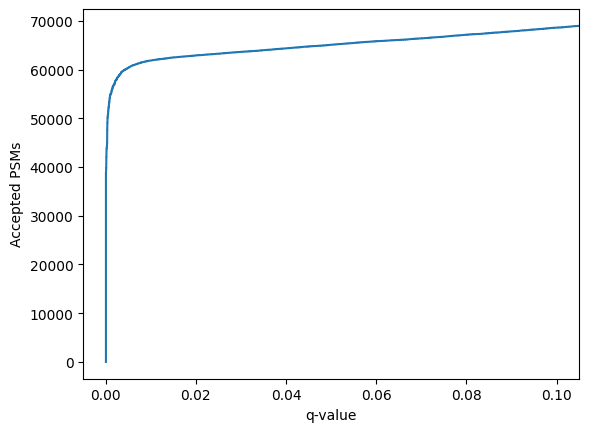

In [40]:
confidence_results.plot_qvalues()
plt.show()

Or to compare the un-rescored PSMs to the rescored PSMs:

In [41]:
linear_psm_dataset.assign_confidence().plot_qvalues(label="Before rescoring")
confidence_results.plot_qvalues(label="After rescoring")
plt.legend()
plt.show()

KeyboardInterrupt: 

Using mokapot directly allows us to quickly generate `LinearPsmDataset` objects with different feature sets, for instance:

- Only basic features
- Basic + MaxQuant-derived features (mimicking a traditional Percolator rescoring run)
- Basic + MaxQuant-derived + MS²PIP features
- Basic + MaxQuant-derived + MS²PIP + DeepLC features


In [ ]:
feature_sets = {
    "basic": feature_names["basic"],
    "basic_ms2pip": feature_names["basic"] + feature_names["ms2pip"],
    "basic_ms2pip_deeplc": feature_names["basic"] + feature_names["ms2pip"] + feature_names["deeplc"],
}

In [ ]:
for feature_set, features in feature_sets.items():
    linear_psm_dataset = convert_psm_list(psm_list, features)
    confidence_results, models = brew(linear_psm_dataset)
    confidence_results.plot_qvalues(label=f"Rescoring with: {feature_set}")

plt.xscale('log')
plt.xlim(1e-4, 1)
plt.legend()
plt.show()

### Using Mokapot within MS²Rescore

Mokapot can also be used for rescoring with the higher-level integration in MS²Rescore. Simply pass
a PSMList object with rescoring features added to the `rescore` function. Doing so will automatically
convert the PSMList to a Mokapot `LinearPsmDataset`, run the `brew` function, and update the original
PSMList with the new scores, q-values and PEPs.

In [ ]:
from ms2rescore.rescoring_engines import mokapot

mokapot.rescore(psm_list)

In [ ]:
score_histogram(psm_list.to_dataframe())